# Bitcoin Forcasting using Deep Learning

![CentraleSupelec Logo](https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo_nouveau.jpg)

In [76]:
__author__ = "Colleville Tanguy","Clement Boulay"
__version__ = "1.0.0"
__maintainer__ = "Colleville Tanguy"
__email__ = ["tanguy.colleville@student-cs.fr","clement.boulay@student-cs.fr"]
__status__ = "Dev"

In [2]:

import os

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from tensorflow.keras.layers import Dense,Bidirectional,Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping

import helper_functions as hf

import warnings
warnings.filterwarnings("ignore")
CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Import Data
Our Data come from https://blockchain.info/.

Here, we load data into a Pandas DataFrame

In [ ]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), delimiter=",")

# Explore Dataset

In [ ]:
df_blockchain.head()

In [ ]:
df_blockchain.columns.sort_values().shape

In [ ]:
df_blockchain.describe()

In [ ]:
print(df_blockchain.info(memory_usage='deep'))## dis le vrai usage de mémoire du df 
print(df_blockchain.memory_usage(deep=True))## stockage par série

In [ ]:
print(df_blockchain.isna().sum())

In [ ]:
print(df_blockchain.shape)
df_blockchain.dropna(axis=0,inplace=True)## drop les lignes où y'a des nan 
print(df_blockchain.shape)

In [ ]:
df_blockchain.dtypes.value_counts().plot.pie()# petit camenbert des différents type du dataframe
plt.show()

In [ ]:
for col in df_blockchain.select_dtypes('float'):## tu peux aussi faire df.select_dtypes(exclude="object") par exemple
    sns.distplot(df_blockchain[col])
    # df.hist(column=col,by="column de ségrégation") --> histogramme
    # df[col].plot.kde() --> densité
    plt.show()

In [ ]:
for col in df_blockchain.select_dtypes('object'):
    print(col)

In [ ]:
Price=df_blockchain["market-price"]

In [ ]:
plt.plot(Price.values)

In [ ]:
plt.plot(df_blockchain["total-bitcoins"]/500)
plt.plot(df_blockchain["market-price"])

In [ ]:
plt.plot(Price[1750:-30])
plt.plot(Price[-30:])

In [ ]:
df_indexed=df_blockchain.set_index("Date")

In [ ]:
df_indexed.index = pd.to_datetime(df_blockchain.set_index("Date").index)
min_year=df_indexed.index.year.min()
max_year=df_indexed.index.year.max()
print("min year", df_indexed.index.year.min())
print("max year",df_indexed.index.year.max())

In [ ]:
colormap=plt.cm.gist_ncar
colost=[colormap(i) for i in np.linspace(0,0.95,1+max_year-min_year)]## len du nb de trucs à plot
print(len(colost))

In [ ]:
df_indexed.index = pd.to_datetime(df_blockchain.set_index("Date").index)
df_blockchain["Year"]=df_indexed.index.year
df_blockchain["Month"]=df_indexed.index.month
df_blockchain["Day"]=df_indexed.index.day
df_blockchain["week_day"]=df_indexed.index.weekday

In [ ]:
plt.figure()
plt.title("Market price over year")
for i in range(min_year,max_year+1,1):
    plt.plot(df_blockchain[df_blockchain["Year"]==i]["market-price"].values,color=colost[i-min_year],label=i)
plt.legend()
plt.grid()

In [ ]:
print(df_blockchain.columns)

In [ ]:
for j in df_blockchain.columns[2:-4]:
    plt.figure()
    for i in range(min_year,max_year+1,1):
        plt.title(f"{j} over year")
        plt.plot(df_blockchain[df_blockchain["Year"]==i][j].values,color=colost[i-min_year],label=i)
        plt.xlabel("year")
        plt.ylabel(j)
        plt.legend()
    plt.grid()
    plt.show()

In [ ]:
target="market-price"
for i in df_blockchain.select_dtypes('float'): 
    print(i)
    plt.figure()
    plt.scatter(df_blockchain[i],df_blockchain[target])
    plt.xlabel(i)
    plt.ylabel(target)
    plt.grid()
    plt.show()

In [ ]:
plt.figure(figsize=(16,7))
sns.heatmap(df_blockchain.corr(),cmap="seismic",annot=True)

In [ ]:
corr_matrix=df_blockchain.corr()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
p=0
coupled=[]
for index, value in sol.items():
    if value>0.9:
        p+=1
        coupled.append(index)
print(p,"features have more than 90% of correlation")

In [ ]:
print(coupled)

In [ ]:
df_blockchain.columns

In [ ]:
features_to_be_dropped=["market-cap","difficulty","n-unique-addresses","n-transactions-excluding-popular","estimated-transaction-volume-usd"]
df_blockchain.drop(features_to_be_dropped,axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(16,7))
sns.heatmap(df_blockchain.corr(),cmap="seismic",annot=True)

In [ ]:
plt.figure()
for i in range(0,7,1):
    plt.title(f"market price over week day ")
    plt.plot(df_blockchain[df_blockchain["week_day"]==i]["market-price"].values,color=colost[i],label=i,alpha=0.7)  
plt.legend()
plt.grid()
plt.show()

In [ ]:
colormap=plt.cm.gist_ncar
colostm=[colormap(i) for i in np.linspace(0,0.95,1+12)]## len du nb de trucs à plot

plt.figure()
for i in range(0,13,1):
    plt.title(f"market price over month ")
    plt.plot(df_blockchain[df_blockchain["Month"]==i]["market-price"].values,label=i,color=colostm[i])
plt.legend()
plt.grid()
plt.show()

In [4]:
def imputation(df):
    """
    Entries : 
        df (pandas DataFrame) : tableau contenant les données brutes (présence de NaN)
    ====================================================================================================
    Aim : 
        Retirer les valeurs NaN des données du tableau
    ====================================================================================================
    Outputs: 
        df (pandas DataFrame) : tableau de données nettoyé des valeurs NaN
    """
    df.dropna(axis=0,inplace=True)
    return(df)

In [5]:
def encodage(df):

    return df 

In [12]:
def feature_engineering(df):  # (création de variable à partir d'une autre)
    """
    Entries : df : pandas DataFrame 
    ====================================================================================================
    Aim : computing new features and dropped thoses which are too much correlated
    ====================================================================================================
    Outputs: df : pandas Dataframe preprocessed
    """
    ########################################################## DATE ##################################################################
    features_to_be_dropped=["market-cap","difficulty","n-unique-addresses","n-transactions-excluding-popular","estimated-transaction-volume-usd","n-transactions-total"]## coreelation
    df.drop(features_to_be_dropped,axis=1,inplace=True)
    df_indexed=df_blockchain.set_index("Date")
    df_indexed.index = pd.to_datetime(df.set_index("Date").index)
    df["Year"]=df_indexed.index.year
    df["Month"]=df_indexed.index.month
    df["Day"]=df_indexed.index.day
    df["week_day"]=df_indexed.index.weekday
    df.index = pd.to_datetime(df.set_index("Date").index)
    df.drop("Date",axis=1,inplace=True)
    ###################################################### TRI DES VALEURS PROPRES ? ################################################# 


    ###################################################### Random Forest #############################################################

    return(df)

In [7]:
def scaler(df):
    """
    Entries : 
        df (pandas DataFrame) : tableau contenant les données brutes (non-standardisées)
    ====================================================================================================
    Aim : 
        Retourner un tableau de données standardisé : pour chaque variable explicative,
        moyenne nulle et écart-type égal à 1.
    
    Outputs: 
        df (pandas DataFrame) : tableau de données standardisé
    """
    scale= StandardScaler()
    columns=df.columns
    df = scale.fit_transform(df)
    df = pd.DataFrame(df, columns=columns)
    return df

In [14]:
def preprocessing(df):
    """
    Entries : 
        df (pandas DataFrame) : tableau contenant les données brutes
    ====================================================================================================
    Aim : 
        Retourner un tableau de données prêt à l'emploi (standardisé, sans NaN, avec des variables explicatives
        sans grande corrélation)
    ====================================================================================================
    Outputs: 
        X -->pandas Dataframe df sans market price
        Y -->pandas serie market price 
        df (pandas DataFrame) : tableau de données prêt à l'emploi
    """
    df = imputation(df)
    df = encodage(df)
    df = feature_engineering(df)
    df = scaler(df)
    X = df.drop('market-price', axis=1)
    y = df["market-price"]
    return X, y,df

# Process data (Making sequences)

here we split and process data before training.

LSTM layer as an input layer expects the data to be 3 dimensions, we will use 'process_data' function to split data into sequences of a fixed length (rnn_size).

The neural network is expecting to have an input's shap of [batch_size, rnn_size, nb_features]

In [15]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), delimiter=",")

In [16]:
X,y,df=preprocessing(df_blockchain)

In [18]:
def splitting(df,start,nb_split,size_test):
    """
    Entries : 
        df (pandas DataFrame)
        start (int) : jour de début de l'étude
        nb_split (int) : represente le nombre de découpe pour la cross validation 
        size_test (int) : représente le nombre de jour du test set 
    ====================================================================================================
    Aim : Créer une liste de X,y pour réaliser une cross validation avec le respect de la temporalité
    ====================================================================================================
    Outputs: 
        list_df_train --> list of df sampled train 
        list_df_test --> list of df sampled test
    """

    tscv = TimeSeriesSplit(n_splits=nb_split, test_size=size_test)
    list_df_train,list_df_test=[],[]
    df=df.iloc[start:]
    for train_index, test_index in tscv.split(df):
        print("TRAIN:", train_index, "TEST:", test_index)
        df_train=df.iloc[train_index[0]:train_index[-1]]
        df_test=df.iloc[test_index[0]:test_index[-1]]
        list_df_test.append(df_test)
        list_df_train.append(df_train)
    return list_df_train,list_df_test

In [19]:
columns=df.columns

In [20]:
def process_data(data, rnn_size=3, target_id=0, columns_size=len(columns)-1):## -1 car on ne veut pas market price dans X 
    """
    Entries:
    data Pandas DataFrame to be processed for RNN 
    rnn_size (int) --> nombre de récurrence d'étude pour le RNN 
    target_id (int) --> nombre de la colonne objectif 

    ====================================================================================================
    Aim: processing X et y for RNN 
    ====================================================================================================
    Outputs:
    X_train (np.array)
    y_train (np.array)
    """
    X = []
    y = []
    for i in range(len(data)-rnn_size):
        X.append(data.iloc[i:i+rnn_size,1:])# pas de market price dans X 
        y.append(data.iloc[i+rnn_size,0])
    return np.array(X).astype(np.float32).reshape((-1,rnn_size,columns_size)), np.array(y).astype(np.float32)

In [21]:
def split_test_train(list_df_train, list_df_test):
    """
    Entries:
    list_df_train (list) : liste contenant les DataFrame du jeu d'entraînement de cross-validation
    list_df_test (list) : liste contenant les DataFrame du jeu de test de cross-validation
    ====================================================================================================
    Aim: Génère 4 listes, une contenant les variables explicatives d'entraînement, une contenant la variable à expliquer d'entraînement et pareil pour le test
    ====================================================================================================
    Outputs:
    list_X_train (list)
    list_X_test (list)
    list_y_train (list)
    list_y_test (list)
    """
    list_X_train, list_X_test, list_y_train, list_y_test = [], [], [], []
    for df_train in list_df_train:
        X_train, y_train = process_data(df_train)
        list_X_train.append(X_train)
        list_y_train.append(y_train)
    for df_test in list_df_test:
        X_test, y_test = process_data(df_test)
        list_X_test.append(X_test)
        list_y_test.append(y_test)
    return list_X_train, list_X_test, list_y_train, list_y_test

In [69]:
list_df_train,list_df_test=splitting(df,2000,5,10)

TRAIN: [   0    1    2 ... 1480 1481 1482] TEST: [1483 1484 1485 1486 1487 1488 1489 1490 1491 1492]
TRAIN: [   0    1    2 ... 1490 1491 1492] TEST: [1493 1494 1495 1496 1497 1498 1499 1500 1501 1502]
TRAIN: [   0    1    2 ... 1500 1501 1502] TEST: [1503 1504 1505 1506 1507 1508 1509 1510 1511 1512]
TRAIN: [   0    1    2 ... 1510 1511 1512] TEST: [1513 1514 1515 1516 1517 1518 1519 1520 1521 1522]
TRAIN: [   0    1    2 ... 1520 1521 1522] TEST: [1523 1524 1525 1526 1527 1528 1529 1530 1531 1532]


In [70]:
list_X_train, list_X_test, list_y_train, list_y_test=split_test_train(list_df_train, list_df_test)

In [72]:
# neural network model

def create_model():
    # Build the model
    callback = EarlyStopping(monitor='loss', patience=3)
    model = keras.Sequential()
    look_back=3 ### rrn size --> à moduler avec la fonction preprodata
    model.add(LSTM(50,batch_input_shape=(None, look_back, len(columns)-1),return_sequences=True,dropout=0.2))
    model.add(Dropout(0.2))
    model.add(LSTM(50,return_sequences=True,dropout=0.2))
    model.add(Dropout(0.2))
    model.add(LSTM(50,return_sequences=True,dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer = "rmsprop", loss = 'mse')
    return model

In [73]:
loss=[]
loss_val=[]
weights=[]
score=[]
# callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
batch_size=32
for i in range(len(list_X_train)):## nveut les entrainements inddpts
    X_train=list_X_train[i]
    y_train=list_y_train[i]
    X_test=list_X_test[i]
    y_test=list_y_test[i]
    model=create_model()
    print("Cross Val no : ", i )
    history=model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = batch_size, epochs = 50)
    loss.append(history.history["loss"])
    loss_val.append(history.history["val_loss"])
    weights.append(model.get_weights())
    # score.append(history.history['accuracy'])

=========================] - 14s 63ms/step - loss: 0.7493 - val_loss: 5.9421
Epoch 2/50
47/47 [==============================] - 1s 16ms/step - loss: 0.3537 - val_loss: 1.5745
Epoch 3/50
47/47 [==============================] - 1s 16ms/step - loss: 0.2498 - val_loss: 0.4973
Epoch 4/50
47/47 [==============================] - 1s 15ms/step - loss: 0.2028 - val_loss: 0.1862
Epoch 5/50
47/47 [==============================] - 1s 15ms/step - loss: 0.1881 - val_loss: 0.4730
Epoch 6/50
47/47 [==============================] - 1s 17ms/step - loss: 0.1767 - val_loss: 0.1196
Epoch 7/50
47/47 [==============================] - 1s 14ms/step - loss: 0.1495 - val_loss: 0.0740
Epoch 8/50
47/47 [==============================] - 1s 14ms/step - loss: 0.1496 - val_loss: 0.0671
Epoch 9/50
47/47 [==============================] - 1s 13ms/step - loss: 0.1426 - val_loss: 0.1792
Epoch 10/50
47/47 [==============================] - 1s 14ms/step - loss: 0.1378 - val_loss: 0.0685
Epoch 11/50
47/47 [============

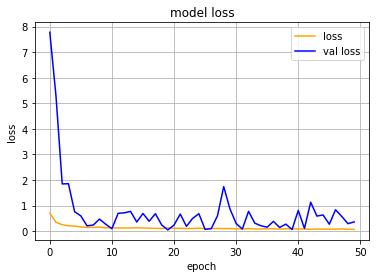

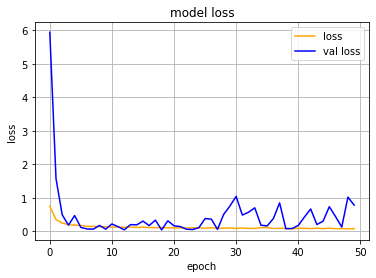

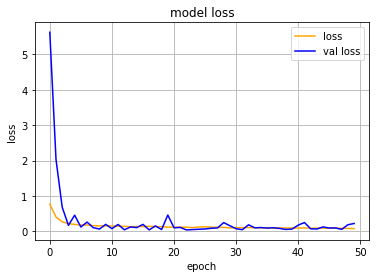

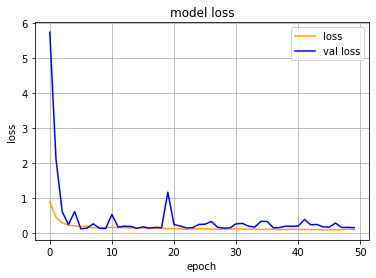

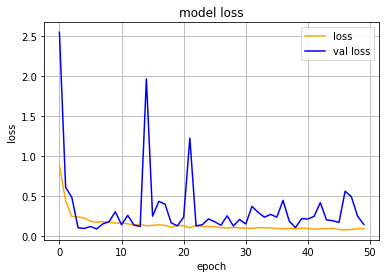

In [74]:
for i in range(len(loss)):
    plt.figure
    plt.plot(loss[i],color="orange",label="loss")
    plt.plot(loss_val[i],color="blue",label="val loss")
    # plt.plot(score[i],color="red",label="val loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

model 0 0.4720709
model 1 0.6549612
model 2 0.4586222
model 3 0.5594261
model 4 0.46772727


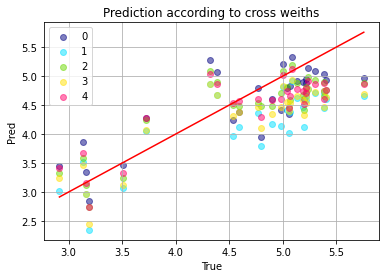

In [83]:
colormap=plt.cm.gist_ncar
colost=[colormap(i) for i in np.linspace(0,0.95,len(weights)+1)]## len du nb de trucs à plot
from sklearn.metrics import mean_squared_error

for p in range(len(weights)):
    old_weights=weights[p]
    new_model = create_model()
    new_model.set_weights(old_weights)
    y_pred=[]
    for i in range(len(list_X_test)):
        pred=new_model.predict(list_X_test[i])
        for j in range(len(pred)):
            y_pred.append(pred[j][0])
    rms = mean_squared_error(np.ravel(list_y_test), y_pred, squared=False)
    print(f"model {p}",rms)
    plt.scatter(np.ravel(list_y_test),y_pred,color=colost[p],alpha=0.5,label=p)
plt.plot(np.linspace(np.min(list_y_test),np.max(list_y_test),len(y_pred)),np.linspace(np.min(list_y_test),np.max(list_y_test),len(y_pred)),color="red")
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("Prediction according to cross weiths")
plt.legend()
plt.grid()

# Evaluation

In [ ]:
# compute prediction for test
y_pred =model.predict(X_test[:3])

In [ ]:
# compute rmse for test
y_pred_inverse = scaler.inverse_transform(np.concatenate([y_pred, data_test[-len(y_pred):,1:]], axis=1))
y_test_inverse = scaler.inverse_transform(data_test.reshape(-1,len(columns)))[rnn_size:]

rmse_score = 
print("rmse score : ", rmse_score)

In [ ]:
#Graphs for predicted values
plt.plot(y_test_inverse[rnn_size:,0], color = 'red', label = 'true BTC price')
plt.plot(y_pred_inverse[:,0], color = 'blue', label = 'predicted BTC price')
plt.title('BTC price Prediction')
plt.xlabel('Days')
plt.ylabel('BTC price')
plt.legend()
plt.show()

In [ ]:
# If you get this far, you can : 
- Test other neural network models
- Test other optimizers
- Compare results between Arima and RNN models
- Find a way to choose most important variables
- ...